In [1]:
import pandas
import math

In [2]:
df = pandas.read_csv('company_directorships.csv')
# df.software_background = df.software_background.map(lambda x: x == 't') - this code is revised as follows:
df['software_background'] = df['software_background'].astype(str).str.lower() == 't' # this code will handle unexpected values and avoid implicit conversion pitfall
df.sample(5)

,company_name,cikcode,director_name,software_background,start_date,end_date
3946,"ENNIS, INC.",33002,EWELL L. TANKERSLEY,False,2001-05-21,2002-05-14
11419,TEAM INC,318833,GRANT ROSCOE,False,2022-09-19,2022-09-19
8166,MEXCO ENERGY CORP,66418,THOMAS H. DECKER,False,2019-07-16,2024-07-22
9968,REALTY INCOME CORP,726728,GERARDO I. LOPEZ,False,2019-04-01,2025-03-26
7559,LEVI STRAUSS & CO,94845,SPENCER C. FLEISCHER,False,2020-02-27,2024-03-14


In [3]:
df.head()

,company_name,cikcode,director_name,software_background,start_date,end_date
0,1ST SOURCE CORP,34782,ALLISON N. EGIDI,False,2011-03-14,2017-03-14
1,1ST SOURCE CORP,34782,ANDREA G. SHORT,False,2023-03-10,2025-03-14
2,1ST SOURCE CORP,34782,CHRISTOPHER J. MURPHY III,True,2008-03-14,2025-03-14
3,1ST SOURCE CORP,34782,CHRISTOPHER J. MURPHY IV,False,2011-03-14,2025-03-14
4,1ST SOURCE CORP,34782,CRAIG A. KAPSON,False,2008-03-14,2017-03-14


cikcode have not been used

In [5]:
compensation_and_demographics_raw = pandas.read_csv('director-details.csv')
compensation_and_demographics_raw['NAME'] = compensation_and_demographics_raw.name.str.upper()

# def most_common(series):
#    mode_values = series.mode()
#    if len(mode_values) > 0:
#        return mode_values[0]
#    return None
# above code have been modified as follow:

def most_common(series):
    try:
        return series.mode().iloc[0]
    except IndexError:
        return None
# The above code will retain functionality but add safer handling for empty series.
    
#compensation_and_demographics = pandas.DataFrame({
#    'age': compensation_and_demographics_raw.groupby('NAME').age.max(),
#    'compensation': compensation_and_demographics_raw.groupby('NAME').compensation.sum(),
#    'gender': compensation_and_demographics_raw.groupby('NAME').gender.agg(most_common)
#}) The above code will be modified as follows:

grouped = compensation_and_demographics_raw.groupby('NAME')
compensation_and_demographics = grouped.agg({
    'age': 'max',
    'compensation': 'sum',
    'gender': most_common
})
# The above code consolidates 'groupby', improves readability, and performance. In the initial code, the groupby function was repeated multiple times, which is inefficient.

# compensation_and_demographics['log_compensation'] = (1 + compensation_and_demographics.compensation).map(math.log10)
# compensation_and_demographics
# The reason for replacing the above code is that 1 + x is arbitrary, which means it can not handle the missing values.

comp = compensation_and_demographics['compensation'].fillna(0)
compensation_and_demographics['log_compensation'] = (comp + 1).apply(math.log10)
# The above code will handle the missing value properly

In [6]:
compensation_and_demographics.gender.value_counts(dropna=False)

gender
male       3850
female     1550
None         19
unknown       2
Name: count, dtype: int64

In [7]:
directorship_counts = df.groupby('director_name').company_name.nunique().sort_values()
directorship_counts

director_name
A CHARLENE SULLIVAN, PH.D.     1
MICHAEL L. KUTA                1
MICHAEL L. LARUSSO             1
MICHAEL L. MILLER              1
MICHAEL L. OWENS               1
                              ..
MARTIN L. FLANAGAN            13
ANN BARNETT STERN             13
TERESA M. RESSEL              13
BRUCE L. CROCKETT             13
ALBERT R. DOWDEN              14
Name: company_name, Length: 11827, dtype: int64

<Axes: xlabel='company_name'>

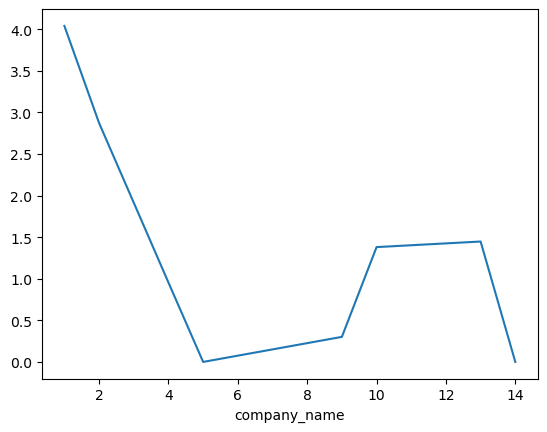

In [8]:
directorship_counts.value_counts().sort_index().map(math.log10).plot()

In [9]:
import networkx
import networkx.algorithms
graph = networkx.Graph()

In [10]:
people = []
companies = []
for company_name, director_name in zip(df.company_name, df.director_name):
    graph.add_edge(company_name, director_name)
    people.append(director_name)
    companies.append(company_name)

In [11]:
biggest_connected_graph = graph.subgraph(list(networkx.connected_components(graph))[0])

In [12]:
%%time
centrality = pandas.DataFrame({
    'eigen': pandas.Series(networkx.eigenvector_centrality(biggest_connected_graph)),
    'degree': pandas.Series(networkx.algorithms.degree_centrality(biggest_connected_graph)),
})
centrality['is_person'] = centrality.index.map(lambda x: x in people)

CPU times: user 1.67 s, sys: 4.46 ms, total: 1.68 s
Wall time: 1.47 s


In the above code, eigenvector and degree centrality measures are used.

In the degree centrality, the node represents directors from various companies and the number of connections(edges) they have with other board of directors from other companies. A director might also be sharing board with other board memebers, which increases the direct connection for that particular director, these directors can be considered as highly invloved and may have board influence through sheer amount of connections.
Whereas in eigenvector centrality, it give information about important the director(node) is not just by direct connections(edge) it has but also by how important it's neighbor are, which means other board of directors. These directors might have fewer connections but the connections they have are highly influential. 

In [15]:
people_df = centrality[centrality.is_person].merge(compensation_and_demographics, left_index=True, right_index=True)

In [16]:
people_df.sort_values('eigen', ascending=False)

,eigen,degree,is_person,age,compensation,gender,log_compensation
ELIZABETH KRENTZMAN,1.024389e-01,0.001585,True,65,3408245,female,6.532531
CAROL DECKBAR,1.024389e-01,0.001585,True,62,43263,female,4.636127
ELI JONES,1.024389e-01,0.001585,True,63,3063255,male,6.486183
DOUGLAS SHARP,1.024389e-01,0.001585,True,50,0,male,0.000000
"JAMES ""JIM"" LIDDY",1.024389e-01,0.001585,True,65,27531,male,4.439838
...,...,...,...,...,...,...,...
JOHN J. GEBBIA,8.400282e-35,0.000122,True,86,120000,male,5.079185
ANDREW S. BORODACH,8.342633e-35,0.000122,True,56,0,male,0.000000
LAWRENCE A. KOBRIN,8.342633e-35,0.000122,True,91,30356,male,4.482259
NANCY J. FLOYD PRUE,8.342633e-35,0.000122,True,70,50356,female,4.702060


In [17]:
df[df.director_name == 'ELIZABETH KRENTZMAN']

,company_name,cikcode,director_name,software_background,start_date,end_date
6297,Invesco Advantage Municipal Income Trust II,908993,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6352,Invesco Bond Fund,5094,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6407,Invesco California Value Municipal Income Trust,895531,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6462,Invesco High Income Trust II,846671,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6512,Invesco Municipal Income Opportunities Trust,835333,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6546,Invesco Municipal Opportunity Trust,884152,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6601,Invesco Municipal Trust,877463,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6656,Invesco Pennsylvania Value Municipal Income Trust,895528,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6706,Invesco Quality Municipal Income Trust,885125,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6740,Invesco Senior Income Trust,1059386,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02


### Add another centrality measure - Betweenness centrality

In [19]:
import networkx as nx
# Betweenness centrality 
bet_cent = nx.betweenness_centrality(biggest_connected_graph)

# Sort and display top 10 by betweenness
top_bet = sorted(bet_cent.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodes by betweenness centrality:")
for node, score in top_bet:
    print(f"{node}: {score:.4f}")

Top 10 nodes by betweenness centrality:
CARDINAL HEALTH INC: 0.0872
RTX Corp: 0.0704
LOWES COMPANIES INC: 0.0672
WHIRLPOOL CORP /DE/: 0.0629
ARMSTRONG WORLD INDUSTRIES INC: 0.0613
GENUINE PARTS CO: 0.0581
CSX CORP: 0.0575
SHERWIN WILLIAMS CO: 0.0538
J. MICHAEL LOSH: 0.0499
TRUIST FINANCIAL CORP: 0.0488


Betweenness centrality is chosen because we need to bridge the gaps between the disconnected parts of the network by looking at the shortest paths. In this method of centrality, the directors will serve a gatekeeping function, which means they are critical for the flow of information and strategic coordination. They might not be highly connected or influential, but they are structurally necessary. 
The above result shows the top 10 directors(nodes) with the shortest path, which tells us how well they are connected to other directors and how the flow of information will be. If any of them is removed, it will make the network less efficient.

In [21]:
import sklearn.cluster

In [22]:
import sklearn.preprocessing
robust_scaler = sklearn.preprocessing.RobustScaler()
age_and_demographics_scaled = robust_scaler.fit_transform(people_df[['age', 'log_compensation', 'degree', 'eigen']])


In [23]:
dbscan = sklearn.cluster.DBSCAN(eps=0.4)
people_df['cluster_id'] = dbscan.fit_predict(age_and_demographics_scaled)
people_df.cluster_id.value_counts()

cluster_id
 1    3117
 0     385
 2     109
-1      72
 3      24
 4      19
 7       8
 6       5
 5       3
Name: count, dtype: int64

<Axes: xlabel='age', ylabel='log_compensation'>

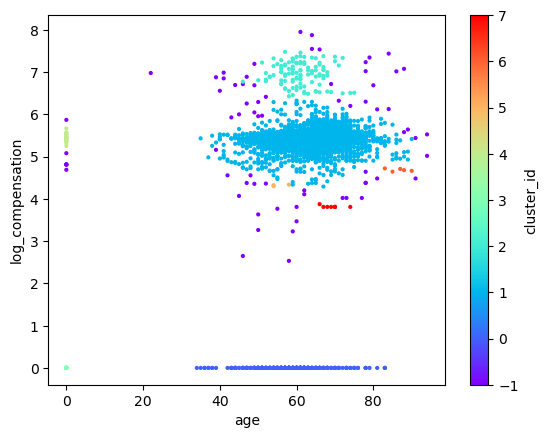

In [24]:
people_df.plot.scatter(x='age', y='log_compensation', c='cluster_id', cmap="rainbow", s=4)

In [25]:
people_df.loc['ELIZABETH KRENTZMAN']

eigen               0.102439
degree              0.001585
is_person               True
age                       65
compensation         3408245
gender                female
log_compensation    6.532531
cluster_id                 2
Name: ELIZABETH KRENTZMAN, dtype: object

https://finance.yahoo.com/sectors/financial-services/shell-companies/
The link above will provide useful insights about the performance of the company in terms of revenue growth, profit margin, share price performance and more. 

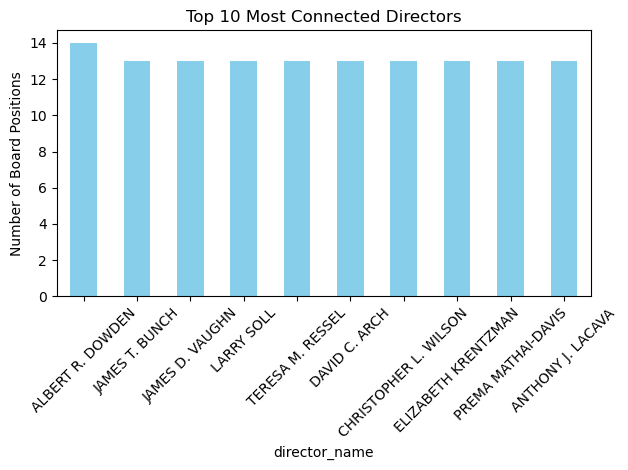

In [27]:
import matplotlib.pyplot as plt
top_directors = df.groupby('director_name').size().sort_values(ascending=False).head(10)
top_directors.plot(kind='bar', color='skyblue')
plt.title("Top 10 Most Connected Directors")
plt.ylabel("Number of Board Positions")
plt.xticks(rotation=45)
plt.tight_layout()

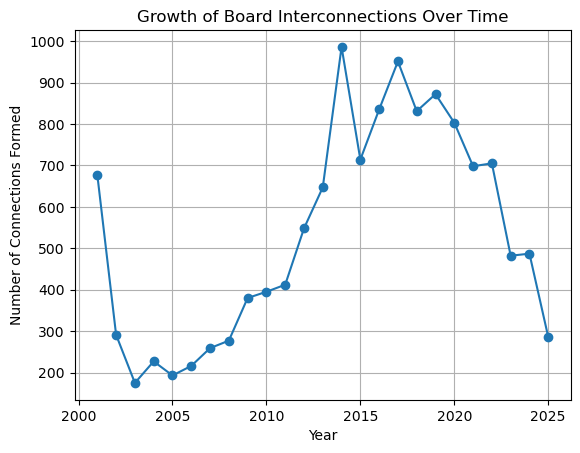

In [28]:
import pandas as pd
df['year'] = pd.to_datetime(df['start_date']).dt.year
connections_by_year = df.groupby('year').size()
connections_by_year.plot(kind='line', marker='o')
plt.title("Growth of Board Interconnections Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Connections Formed")
plt.grid(True)

Text(0.5, 1.0, 'How Many Boards Does Each Director Sit On?')

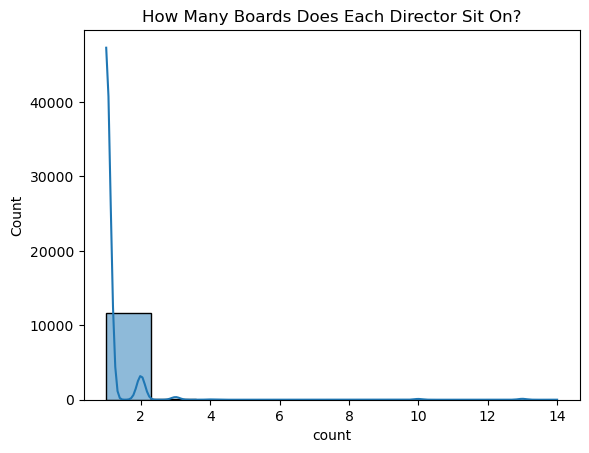

In [29]:
import seaborn as sns
sns.histplot(df['director_name'].value_counts(), bins=10, kde=True)
plt.title("How Many Boards Does Each Director Sit On?")

The data contains highly sensitive information about the board of directors, which can provide valuable insights into corporate governance, power structures, and other relevant information. There are a few ethical concerns that should be kept in mind during the analysis and ensure there is no violation of individual privacy. Firstly, we should ensure transparency and accountability, The purpose is to ensure that the whole process is transparent and promote accountability in corporate governance. Secondly, the data contains personal details of the directors, which are used for director network analysis. We should deal with the data properly to ensure that the data is not leaked and is only used for network analysis purposes. Lastly, we should respect consent and fair use of data, even with publicly available data; ethical research should respect the spirit of informed consent.
We should ensure details of the individuals are kept confidential, and communicate data sources, limitations, and assumptions in any public-facing outputs.